<a href="https://colab.research.google.com/github/souldrive7/ECP/blob/main/DT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 決定木

In [1]:
from sklearn.tree import DecisionTreeClassifier  # 決定木分類器
from sklearn.datasets import fetch_openml  # データセットのダウンロード取得用
import pandas as pd  # データフレーム操作用
import matplotlib.pyplot as plt  # グラフ描画用

In [2]:
# 1. データセットの取得
dataset = fetch_openml("pima-indians-diabetes", version=1, as_frame=True)  # Pimaデータセットを取得
# こんな感じのデータです．8変数の説明変数．Outcomeは0 or 1
dataset.frame.head()  # データフレームの最初の5行を表示

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.0,0.0,33.6,0.627,50.0,1.0
1,1.0,85.0,66.0,29.0,0.0,26.6,0.351,31.0,0.0
2,8.0,183.0,64.0,0.0,0.0,23.3,0.672,32.0,1.0
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0.0
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,1.0


In [3]:
# 1.1 参考までに相関行列を表示
corr = dataset.frame.corr()
# 相関行列をヒートマップで表示．有効数字2桁
corr.style.format(precision=2).background_gradient(cmap="coolwarm")

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.00,0.13,0.14,-0.08,-0.07,0.02,-0.03,0.54,0.22
Glucose,0.13,1.00,0.15,0.06,0.33,0.22,0.14,0.26,0.47
BloodPressure,0.14,0.15,1.00,0.21,0.09,0.28,0.04,0.24,0.07
SkinThickness,-0.08,0.06,0.21,1.00,0.44,0.39,0.18,-0.11,0.07
Insulin,-0.07,0.33,0.09,0.44,1.00,0.20,0.19,-0.04,0.13
BMI,0.02,0.22,0.28,0.39,0.20,1.00,0.14,0.04,0.29
DiabetesPedigreeFunction,-0.03,0.14,0.04,0.18,0.19,0.14,1.00,0.03,0.17
Age,0.54,0.26,0.24,-0.11,-0.04,0.04,0.03,1.00,0.24
Outcome,0.22,0.47,0.07,0.07,0.13,0.29,0.17,0.24,1.00


In [6]:
# こっちの方が汎用性が高いです．PandasのDataFrameから変換する方法
df = dataset.frame
X = df.drop(columns=["Outcome"])  # Outcome列を除外
y = df["Outcome"].astype(int)  # Outcome列を抽出 & 整数型に変換

In [7]:
# 3. 訓練データとテストデータに分割
from sklearn.model_selection import train_test_split  # データ分割用
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=500)  # 80%訓練，20%テスト

In [86]:
# 4. 決定木を使って学習
#model = DecisionTreeClassifier()
#model = DecisionTreeClassifier(max_depth=3)  # 深さ3の決定木
model = DecisionTreeClassifier(criterion="gini", ccp_alpha=0.005)
model.fit(X_train, y_train)  # 学習

DecisionTreeClassifier(ccp_alpha=0.005)

In [87]:
from sklearn.metrics import accuracy_score  # 精度評価用
# 4.1 （意味ないけど）訓練データでの精度を確認
y_train_pred = model.predict(X_train)  # 訓練データで予測
accuracy_train = accuracy_score(y_train, y_train_pred)  # 精度計算
print(f"Train accuracy: {accuracy_train:.3f}")  # 精度表示 ⇒ 枝刈りしてない場合1になります．

Train accuracy: 0.814


In [88]:
# 5. テストデータで予測
y_pred = model.predict(X_test)  # 予測
# 6. 精度を評価
accuracy = accuracy_score(y_test, y_pred)  # 精度計算
print(f"Accuracy: {accuracy:.3f}")  # 精度を表示(小数点以下3桁)

Accuracy: 0.753


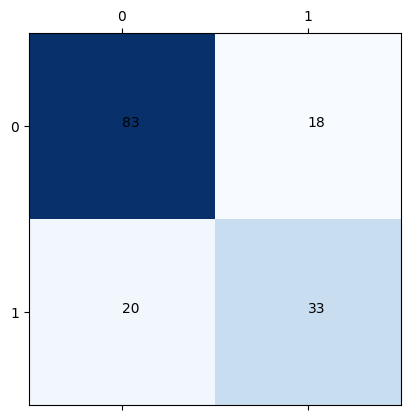

In [89]:
# 7. 混同行列を表示
from sklearn.metrics import confusion_matrix  # 混同行列用
cm = confusion_matrix(y_test, y_pred)  # 混同行列を計算
plt.matshow(cm, cmap="Blues")  # 混同行列をヒートマップで表示
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(x=j, y=i, s=cm[i, j])

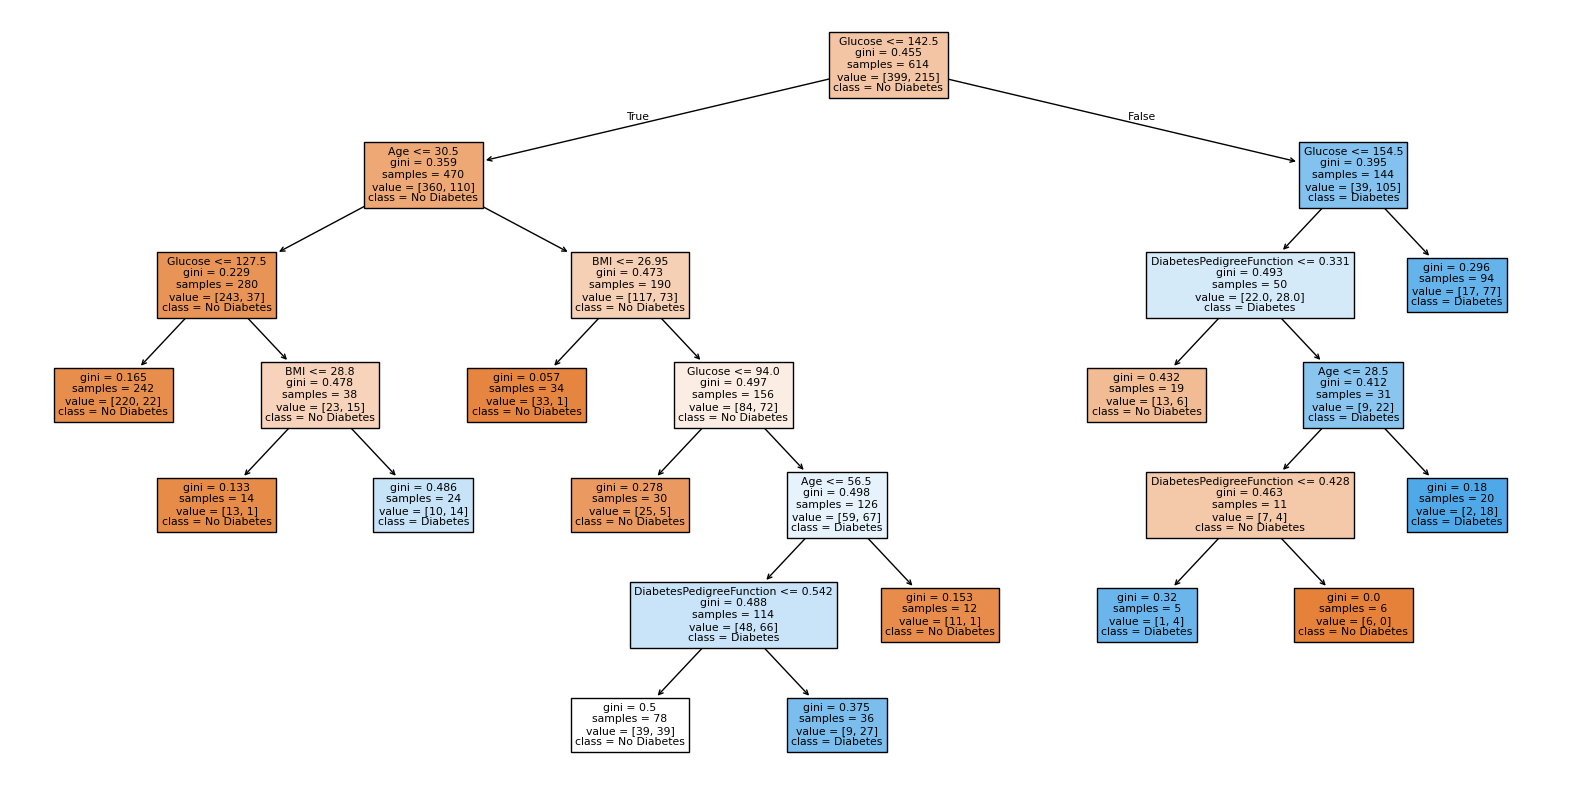

In [90]:
# 8. 決定木を表示
from sklearn.tree import plot_tree  # 決定木表示用
plt.figure(figsize=(20, 10))  # 図のサイズを指定
plot_tree(model, filled=True, feature_names=X.columns, class_names=["No Diabetes", "Diabetes"])  # 決定木を表示
plt.show()  # 図を表示


Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

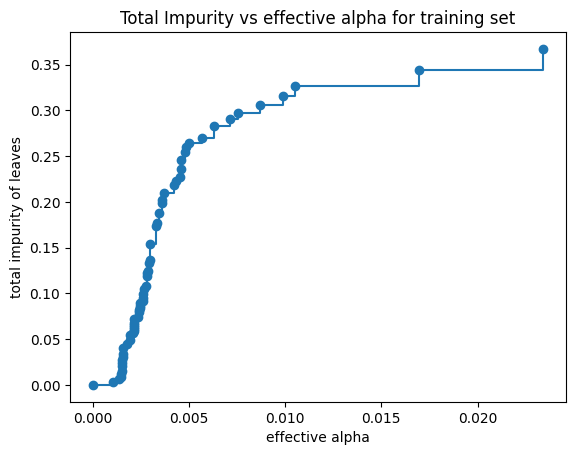

In [91]:
# 発展 : https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html

# 9. 決定木の枝刈り
path = model.cost_complexity_pruning_path(X_train, y_train)  # 枝刈りのコスト複雑度を計算
ccp_alphas, impurities = path.ccp_alphas, path.impurities # α_effとジニ不純度

# α_effを使って枝刈りした場合のジニ不純度の変化を表示
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")


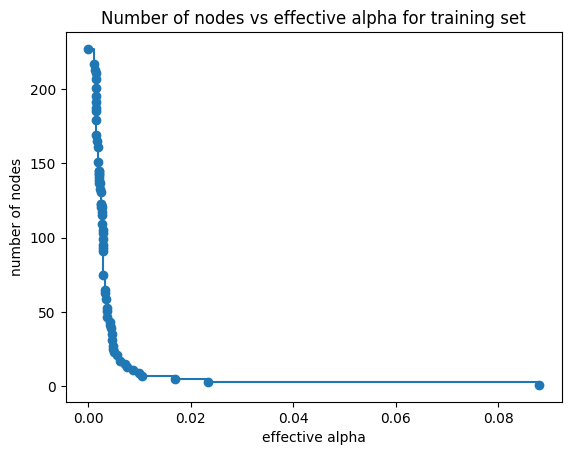

In [92]:
models = []
nodes = []
# いろんなccp_alphaを使って決定木を学習
for ccp_alpha in ccp_alphas:
    model = DecisionTreeClassifier(ccp_alpha=ccp_alpha)
    model.fit(X_train, y_train)
    models.append(model)
    nodes.append(model.tree_.node_count)  # 各決定木のノード数を保存

# ノード数とccp_alphaの関係を表示
fig, ax = plt.subplots()
ax.plot(ccp_alphas, nodes, marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("number of nodes")
ax.set_title("Number of nodes vs effective alpha for training set")
plt.show()


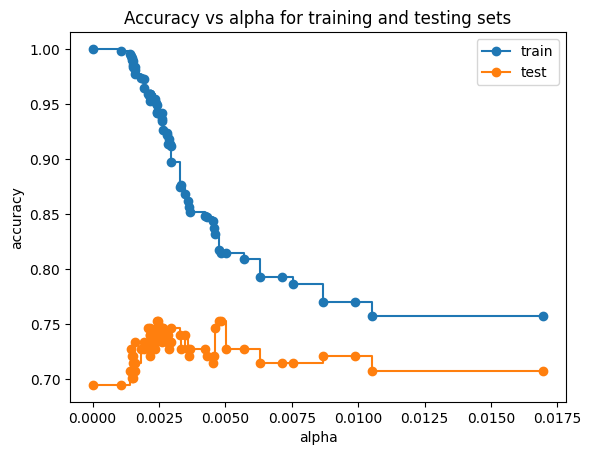

In [93]:
# 訓練データとテストデータでの精度を計算
train_scores = [model.score(X_train, y_train) for model in models]
test_scores = [model.score(X_test, y_test) for model in models]

# 横軸：ccp_alpha，縦軸：精度
# グラフを見やすくするために，ccp_alphaの最後の2つの値を表示から外してます
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas[:-2], train_scores[:-2], marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas[:-2], test_scores[:-2], marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [94]:
# 注：X_testとy_testを使って，どのccp_alphaが最適かを選ぶのは，データリークになるので注意してください．
# 本来は，訓練用，検証用，テスト用の3つのデータセットを用意して，
# 訓練用データで学習，検証用データでccp_alphaを選び，テスト用データで最終的な精度を評価するのが正しいやり方です．
ccp_alpha = 0.0048
model = DecisionTreeClassifier(ccp_alpha=ccp_alpha)  # 決定木を学習
model.fit(X_train, y_train)  # 学習


DecisionTreeClassifier(ccp_alpha=0.0048)

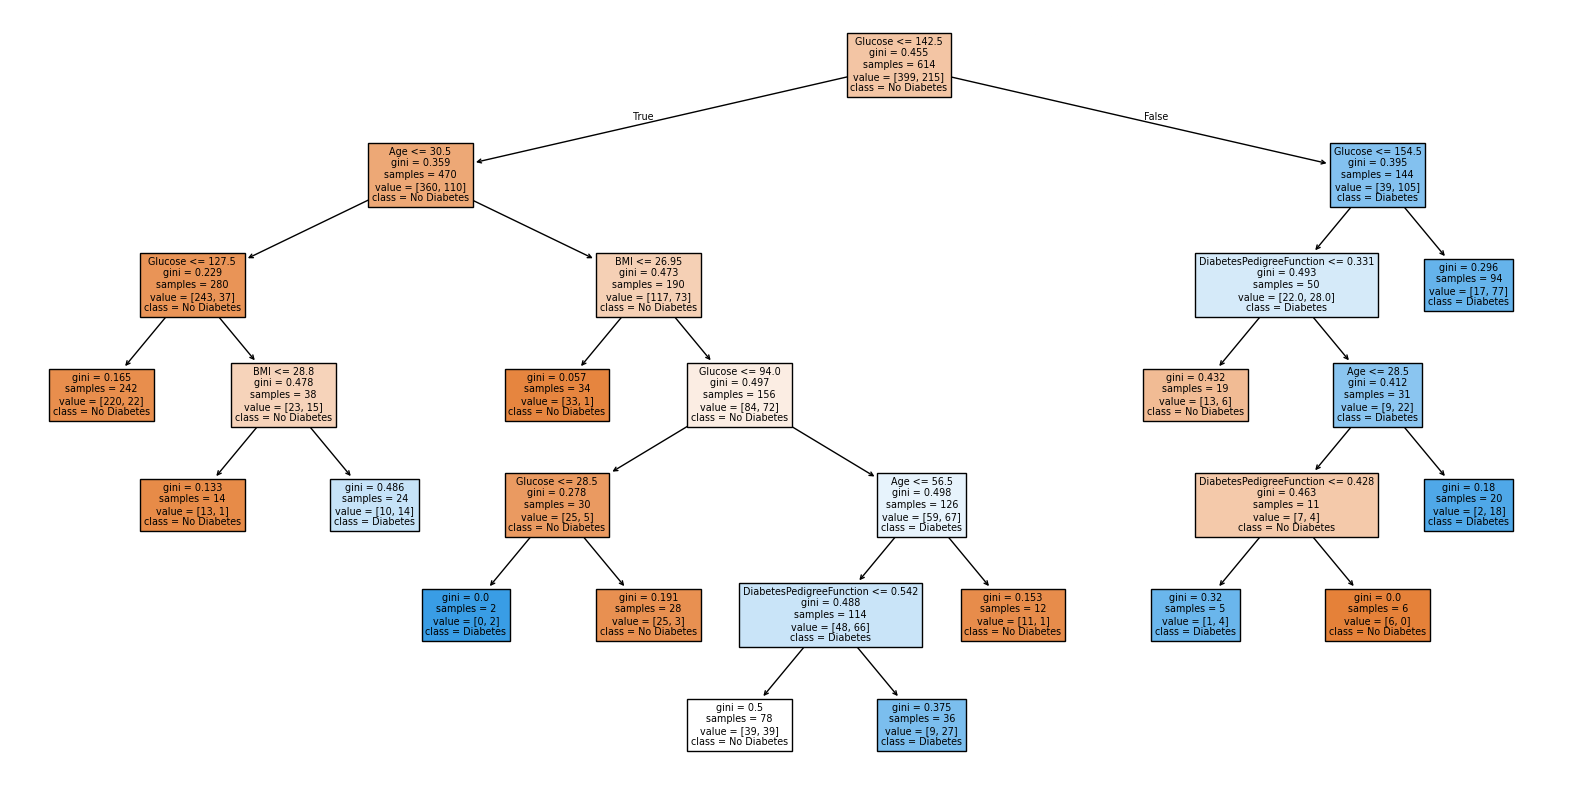

In [95]:
# 8. 決定木を表示
from sklearn.tree import plot_tree  # 決定木表示用
plt.figure(figsize=(20, 10))  # 図のサイズを指定
plot_tree(model, filled=True, feature_names=X.columns, class_names=["No Diabetes", "Diabetes"])  # 決定木を表示
plt.show()  # 図を表示